In [1]:
%%capture
!pip install gdown
!pip install einops

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
from einops import rearrange
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

Mounted at /content/drive
cpu


In [3]:
# BATCH_SIZE = 4096 # 논문의 값 (pre-training)
BATCH_SIZE = 32
# LAMBDA = 1e-1 # l2-Regularization룰 위한 hyperparam. # 논문의 값 (pre-training)
LAMBDA = 3e-1 # 저장된 모델
EPOCH = 50 # 저장된 모델

scheduler_name = 'Cos' # 저장된 모델 (fine-tuning시 cos decay 썼다고 함)
#### Noam ####
warmup_steps = 1000 # 데이터 수 * EPOCH / BS = 총 step 수 인것 고려
LR_scale = 0.5 # Noam scheduler에 peak LR 값 조절을 위해 곱해질 녀석
### Linear ###
warmup_steps = 12000
LR_peak = 1e-3
#### Cos ####
LR_init = 1e-4 # 저장된 모델
#### Constant ####
LR = 1e-4

criterion = nn.CrossEntropyLoss()

new_model_train = False
hyuk_model_use = True # 여러분만의 모델 만들어서 사용하고 싶다면 False로
if hyuk_model_use:
    !gdown https://drive.google.com/uc?id=1hR3AdqN0gnhV3JYJ6KQYBxv7mZpLxrBO -O ViT_CIFAR10.pt
    !gdown https://drive.google.com/uc?id=1guHKi96Fym8CNJjK_hUxwhIhAjR_mCsQ -O ViT_CIFAR10_history.pt
    save_model_path = 'ViT_CIFAR10.pt'
    save_history_path = 'ViT_CIFAR10_history.pt'
else:
    save_model_path = '/content/drive/MyDrive/Colab Notebooks/results/ViT_CIFAR10_2.pt'
    save_history_path = '/content/drive/MyDrive/Colab Notebooks/results/ViT_CIFAR10_2_history.pt'

Downloading...
From (original): https://drive.google.com/uc?id=1hR3AdqN0gnhV3JYJ6KQYBxv7mZpLxrBO
From (redirected): https://drive.google.com/uc?id=1hR3AdqN0gnhV3JYJ6KQYBxv7mZpLxrBO&confirm=t&uuid=5fc09307-89fe-42dd-9516-a2d18f5d5d73
To: /content/ViT_CIFAR10.pt
100% 30.2M/30.2M [00:00<00:00, 102MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1guHKi96Fym8CNJjK_hUxwhIhAjR_mCsQ
To: /content/ViT_CIFAR10_history.pt
100% 2.84k/2.84k [00:00<00:00, 9.24MB/s]


In [4]:
transform_train = transforms.Compose([
    # transforms.RandomResizedCrop(scale=(0.9,1), ratio=(0.3,1.7), size=(32,32)),

    transforms.RandomGrayscale(p=0.1),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),

    transforms.RandomHorizontalFlip(p=0.4), # p 확률로 좌우반전
    # transforms.RandomVerticalFlip(p=0.5), # p 확률로 상하반전
    # transforms.RandomAffine(degrees=(0,90),translate=(0.1,0.2),scale=(0.9,1.1)),
    # transforms.RandomPerspective(distortion_scale=0.1, p=0.1), # distortion 정도 0~1 사이, default는 0.5, p는 적용 확률

    transforms.ToTensor(), # 얘는 항상 살려줘야함

    transforms.RandomErasing(p=0.1, scale=(0.03,0.08), ratio=(0.3,3.3)), # ToTensor 뒤에 와야
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

transform_test = transforms.ToTensor()

train_DS = datasets.CIFAR10(root = '/content/drive/MyDrive/Colab Notebooks/data', train=True, download=True, transform=transform_train)
train_DS, val_DS = torch.utils.data.random_split(train_DS, [45000, 5000])
test_DS = datasets.CIFAR10(root = '/content/drive/MyDrive/Colab Notebooks/data', train=False, download=True, transform=transform_test)

train_DL = torch.utils.data.DataLoader(train_DS, batch_size = BATCH_SIZE, shuffle = True)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size = BATCH_SIZE, shuffle = True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size = BATCH_SIZE, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


image size = torch.Size([3, 32, 32])
image size = torch.Size([3, 32, 32])


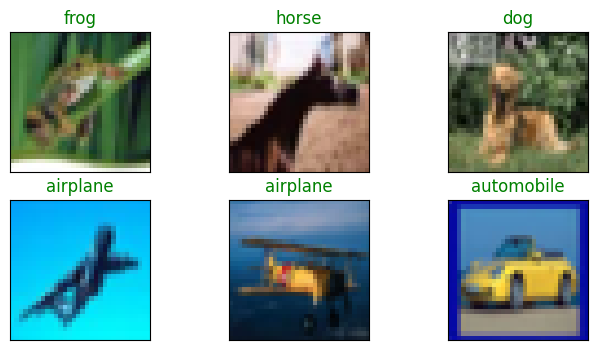

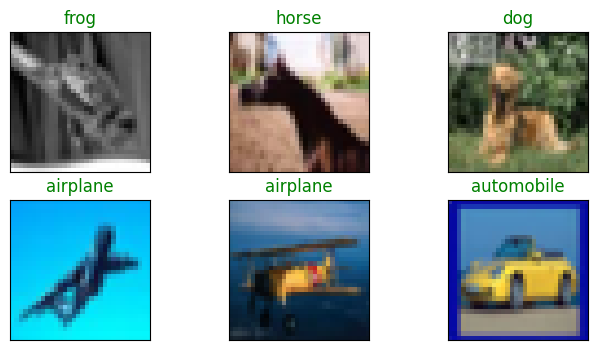

In [5]:
from PIL import Image
def im_plot(x_numpy, y_batch, transform):
    plt.figure(figsize=(8,4))
    for idx in range(6):
        im = Image.fromarray(x_numpy[idx])
        im = transform(im)
        im = im-im.min() # for imshow clipping
        im = im/im.max() # for imshow clipping

        plt.subplot(2,3, idx+1, xticks=[], yticks=[])
        plt.imshow(im.permute(1,2,0))
        true_class = test_DS.classes[y_batch[idx]]
        plt.title(true_class, color = "g")
    print(f"image size = {im.shape}")

idx = torch.randint(0,10000,(6,))
x_batch = test_DS.data[idx]
targets = torch.tensor(test_DS.targets) # 리스트라서 텐서로 바꿔줌 (random idx로 인덱싱 하기위해)
y_batch = targets[idx]
im_plot(x_batch, y_batch, transform_test)
im_plot(x_batch, y_batch, transform_train)

## 모델 구현

In [6]:
class MHA(nn.Module):
    def __init__(self, hidden_dim, n_heads):
        super().__init__()

        self.n_heads = n_heads

        self.fc_q = nn.Linear(hidden_dim, hidden_dim)
        self.fc_k = nn.Linear(hidden_dim, hidden_dim)
        self.fc_v = nn.Linear(hidden_dim, hidden_dim)
        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.scale = torch.sqrt(torch.tensor(hidden_dim / n_heads))

        nn.init.xavier_uniform_(self.fc_q.weight) # https://github.com/pytorch/pytorch/blob/main/torch/nn/modules/activation.py#L1041 참고해서 나름 변형함
        nn.init.xavier_uniform_(self.fc_k.weight)
        nn.init.xavier_uniform_(self.fc_v.weight)
        nn.init.xavier_uniform_(self.fc_o.weight)

        if self.fc_q.bias is not None:
            nn.init.constant_(self.fc_q.bias, 0)
        if self.fc_k.bias is not None:
            nn.init.constant_(self.fc_k.bias, 0)
        if self.fc_v.bias is not None:
            nn.init.constant_(self.fc_v.bias, 0)
        if self.fc_o.bias is not None:
            nn.init.constant_(self.fc_o.bias, 0)

    def forward(self, x):

        Q = self.fc_q(x) # 개단차
        K = self.fc_k(x)
        V = self.fc_v(x)

        Q = rearrange(Q, '개 단 (헤 차) -> 개 헤 단 차', 헤 = self.n_heads) # 개단차 -> 개헤단차
        K = rearrange(K, '개 단 (헤 차) -> 개 헤 단 차', 헤 = self.n_heads)
        V = rearrange(V, '개 단 (헤 차) -> 개 헤 단 차', 헤 = self.n_heads)

        attention_score = Q @ K.transpose(-2,-1)/self.scale # 개헤단단

        attention_weights = torch.softmax(attention_score, dim=-1) # 개헤단단

        attention = attention_weights @ V # 개헤단차

        x = rearrange(attention, '개 헤 단 차 -> 개 단 (헤 차)') # 개헤단차 -> 개단차
        x = self.fc_o(x) # 개단차

        return x, attention_weights

class FeedForward(nn.Module):
    def __init__(self, hidden_dim, d_ff, drop_p):
        super().__init__()

        self.linear = nn.Sequential(nn.Linear(hidden_dim, d_ff),
                                    nn.GELU(),
                                    nn.Dropout(drop_p),
                                    nn.Linear(d_ff, hidden_dim))

    def forward(self, x):
        x = self.linear(x)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, d_ff, n_heads, drop_p):
        super().__init__()

        self.self_atten_LN = nn.LayerNorm(hidden_dim, eps=1e-6)
        self.self_atten = MHA(hidden_dim, n_heads)

        self.FF_LN = nn.LayerNorm(hidden_dim, eps=1e-6)
        self.FF = FeedForward(hidden_dim, d_ff, drop_p)

        self.dropout = nn.Dropout(drop_p)

    def forward(self, x):

        residual = self.self_atten_LN(x)
        residual, atten_enc = self.self_atten(residual)
        residual = self.dropout(residual)
        x = x + residual

        residual = self.FF_LN(x)
        residual = self.FF(residual)
        residual = self.dropout(residual)
        x = x + residual

        return x, atten_enc

class Encoder(nn.Module):
    def __init__(self, seq_length, n_layers, hidden_dim, d_ff, n_heads, drop_p):
        super().__init__()

        self.pos_embedding = nn.Parameter(0.02*torch.randn(seq_length, hidden_dim)) # 행렬로 pos embedding 표현
        # 0.02 는 https://github.com/pytorch/vision/blob/01b9faa16cfeacbb70aa33bd18534de50891786b/torchvision/models/vision_transformer.py#L139 참고
        self.dropout = nn.Dropout(drop_p)
        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, d_ff, n_heads, drop_p) for _ in range(n_layers)])
        self.ln = nn.LayerNorm(hidden_dim, eps=1e-6)

    def forward(self, src, atten_map_save = False): # src.shape = 개단차

        x = src + self.pos_embedding.expand_as(src) # 개단차
        x = self.dropout(x)

        atten_encs = torch.tensor([]).to(DEVICE)
        for layer in self.layers:
            x, atten_enc = layer(x)
            if atten_map_save is True:
                atten_encs = torch.cat([atten_encs , atten_enc[0].unsqueeze(0)], dim=0) # 층헤단단 ㅋ

        x = x[:,0,:] # CLS의 출력 임베딩 벡터. shape=개차
        x = self.ln(x) # https://github.com/pytorch/vision/blob/01b9faa16cfeacbb70aa33bd18534de50891786b/torchvision/models/vision_transformer.py#L157 에서 인코더에 해놓음
        # 논문의 수식 (4), pre-activation 구조를 채택했기 때문에 ln을 마지막에 해준다!

        return x, atten_encs

class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, n_layers, hidden_dim, d_ff, n_heads, representation_size = None, drop_p = 0., num_classes = 1000):
        super().__init__()

        self.hidden_dim = hidden_dim # optimizer 선언 시 필요

        seq_length = (image_size // patch_size) ** 2 + 1 # +1 은? cls 토큰!

        self.class_token = nn.Parameter(torch.zeros(hidden_dim))
        self.input_embedding = nn.Conv2d(3, hidden_dim, patch_size, stride=patch_size) # 통과 후, 한 픽셀이 한 패치를 담고 있게 된다!
        self.encoder = Encoder(seq_length, n_layers, hidden_dim, d_ff, n_heads, drop_p)

        heads_layers = []
        if representation_size is None:
            self.head = nn.Linear(hidden_dim, num_classes) # fine-tune 할 땐 이렇게
        else:
            self.head = nn.Sequential(nn.Linear(hidden_dim, representation_size), # pre-training 할 땐 MLP로 했다고 함
                                      nn.Tanh(), # tanh? why? 논문에 이유는 안써잇고 그냥 그렇게 했다고 함
                                      nn.Linear(representation_size, num_classes))
        # https://github.com/pytorch/vision/blob/01b9faa16cfeacbb70aa33bd18534de50891786b/torchvision/models/vision_transformer.py#L235 참고

        # conv weight 초기화.
        # 초기화는 https://github.com/pytorch/vision/blob/01b9faa16cfeacbb70aa33bd18534de50891786b/torchvision/models/vision_transformer.py#L245 참고
        fan_in = self.input_embedding.in_channels * self.input_embedding.kernel_size[0] * self.input_embedding.kernel_size[1]
        nn.init.trunc_normal_(self.input_embedding.weight, std=math.sqrt(1 / fan_in))
        if self.input_embedding.bias is not None:
            nn.init.zeros_(self.input_embedding.bias)
        # Linear weight 초기화
        if representation_size is None: # representation_size is None 은 fine-tuning 함을 의미 (MLP 안쓰는 거니까)
            nn.init.zeros_(self.head.weight) # 논문에선 fine-tune 시 zero-init이 좋았다고 함
            nn.init.zeros_(self.head.bias) # backprop=액웨액웨..인데 마지막 layer는 0-init 해도 되는 이유가 뭘까요?
        else: # pre-training 때
            fan_in = self.head[0].in_features
            nn.init.trunc_normal_(self.head[0].weight, std=math.sqrt(1 / fan_in))
            nn.init.zeros_(self.head[0].bias)
            # fine-tune 이 아닐 때는 마지막 layer init 어떻게 해야할지 언급 딱히 없음

    def forward(self, x): # x.shape = 개채행열

        x = self.input_embedding(x) # 개채행열 => 개차단h단w
        x = rearrange(x, '개 차 단h 단w -> 개 (단h 단w) 차') # 개차단h단w => 개단차

        batch_class_token = self.class_token.expand(x.shape[0], 1, -1) # 개1차
        x = torch.cat([batch_class_token, x], dim=1) # 개(단+1)차

        enc_out, atten_encs = self.encoder(x) # 개(단+1)차

        x = self.head(enc_out)

        return x, atten_encs

In [7]:
# rearrange 로 개채행열을 개차단으로 바꾸는 것 확인
hidden_dim = 5
patch_size = 2
x = torch.randn(1,3,6,6) # 개채행열
print(x)

input_embedding = nn.Conv2d(3, hidden_dim, patch_size, stride=patch_size)
x = input_embedding(x) # 개채행열 => 개차단단
print(x.shape)
print(x)
x = rearrange(x, '개 차 단1 단2 -> 개 (단1 단2) 차') # 개차단단 => 개단차
# 글 읽듯이 왼쪽->오른쪽 위->아래 순으로 패치가 행으로 놓이게 된다.
print(x.shape)
print(x)

tensor([[[[-1.3484, -0.0146, -0.5597, -1.4139,  0.6174,  0.4544],
          [-1.4061, -1.2785,  0.0451, -0.6621, -1.1488,  2.4671],
          [-0.4683, -0.0488,  0.7117, -0.5556, -2.5348,  0.6136],
          [-1.3927, -0.8475, -0.2061,  0.6996, -0.8341,  0.3846],
          [ 0.8032, -0.9207,  0.3035,  2.2081,  0.2580,  0.4220],
          [-1.2095, -0.2919,  1.2659, -0.0769, -0.2623,  0.6606]],

         [[ 0.4787,  0.4427, -0.6410,  0.6605,  0.4052,  0.9531],
          [ 0.2174, -0.1166,  0.2912, -0.7114,  0.6018, -0.9833],
          [-0.6664, -0.2685, -0.0427, -1.1602,  0.4794, -0.0474],
          [ 0.3798,  0.6999,  0.9508, -0.1844,  1.4687, -1.2171],
          [ 0.2181,  0.2841,  0.5757, -0.2379,  1.2271,  0.2429],
          [-0.1715,  0.8853,  1.6390, -0.7289, -0.0347, -0.0687]],

         [[ 1.8992, -0.5475,  0.1777,  1.2518, -0.2713, -0.7994],
          [ 1.0121,  1.4961,  0.0232, -0.1832, -0.3796,  0.2502],
          [ 0.4478,  1.6433,  0.2621,  0.1051,  1.9402, -0.6816],
      

## 모델 생성

In [9]:
# representation_size 는 MLP head의 hidden layer node 수인데, GPT한데 물어보고 정함 (git 코드에서는 딱히 알 수 없었어요)
def vit_b_16(**kwargs):
    return VisionTransformer(image_size = 224, patch_size = 16, n_layers = 12, hidden_dim = 768, d_ff = 3072, n_heads = 12, representation_size = 768, **kwargs)

def vit_b_32(**kwargs):
    return VisionTransformer(image_size = 224, patch_size = 32, n_layers = 12, hidden_dim = 768, d_ff = 3072, n_heads = 12, representation_size = 768, **kwargs)

def vit_l_16(**kwargs):
    return VisionTransformer(image_size = 224, patch_size = 16, n_layers = 24, hidden_dim = 1024, d_ff = 4096, n_heads = 16, representation_size = 1024, **kwargs)

def vit_l_32(**kwargs):
    return VisionTransformer(image_size = 224, patch_size = 32, n_layers = 24, hidden_dim = 1024, d_ff = 4096, n_heads = 16, representation_size = 1024, **kwargs)

def vit_h_14(**kwargs):
    return VisionTransformer(image_size = 224, patch_size = 14, n_layers = 32, hidden_dim = 1280, d_ff = 5120, n_heads = 16, representation_size = 1280, **kwargs)

def vit_cifar10(**kwargs):
    return VisionTransformer(image_size = 32, patch_size = 2, n_layers = 3, hidden_dim = 256, d_ff = 1024, n_heads = 8, representation_size = 256, **kwargs)

In [10]:
# model = vit_b_16(num_classes = 10).to(DEVICE)
# model = vit_b_32(num_classes = 10).to(DEVICE)
model = vit_cifar10(num_classes = 10).to(DEVICE)

In [ ]:
!pip install torchinfo
from torchinfo import summary
# summary(model, input_size=(2,3,224,224), device=DEVICE)
summary(model, input_size=(2,3,32,32), device=DEVICE)

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [2, 10]                   256
├─Conv2d: 1-1                                 [2, 256, 16, 16]          3,328
├─Encoder: 1-2                                [2, 256]                  65,792
│    └─Dropout: 2-1                           [2, 257, 256]             --
│    └─ModuleList: 2-2                        --                        --
│    │    └─EncoderLayer: 3-1                 [2, 257, 256]             789,760
│    │    └─EncoderLayer: 3-2                 [2, 257, 256]             789,760
│    │    └─EncoderLayer: 3-3                 [2, 257, 256]             789,760
│    └─LayerNorm: 2-3                         [2, 256]                  512
├─Sequential: 1-3                             [2, 10]                   --
│    └─Linear: 2-4                            [2, 256]                  65,792
│    └─Tanh: 2-5                              [2, 256]             

In [ ]:
x_batch, _ = next(iter(train_DL))
print(model(x_batch.to(DEVICE))[0].shape)

torch.Size([32, 10])


## Train, Test, loss_epoch 함수

In [ ]:
def Train(model, train_DL, val_DL, criterion, optimizer, scheduler = None):
    loss_history = {"train": [], "val": []}
    acc_history = {"train": [], "val": []}
    best_loss = 9999
    for ep in range(EPOCH):
        model.train() # train mode로 전환
        train_loss, train_acc, _ = loss_epoch(model, train_DL, criterion, optimizer = optimizer, scheduler = scheduler)
        loss_history["train"] += [train_loss]
        acc_history["train"] += [train_acc]

        model.eval() # test mode로 전환
        with torch.no_grad():
            val_loss, val_acc, _ = loss_epoch(model, val_DL, criterion)
            loss_history["val"] += [val_loss]
            acc_history["val"] += [val_acc]
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save({"model": model,
                            "ep": ep,
                            "optimizer": optimizer,
                            "scheduler": scheduler}, save_model_path)
        # print loss
        print(f"Epoch: {ep+1}, current_LR = {optimizer.param_groups[0]['lr']:.8f}")
        print(f"train loss: {train_loss:.5f}, "
              f"val loss: {val_loss:.5f} \n"
              f"train acc: {train_acc:.1f} %, "
              f"val acc: {val_acc:.1f} %")
        print("-" * 20)

    torch.save({"loss_history": loss_history,
                "acc_history": acc_history,
                "EPOCH": EPOCH,
                "BATCH_SIZE": BATCH_SIZE}, save_history_path)

def Test(model, test_DL, criterion):
    model.eval() # test mode로 전환
    with torch.no_grad():
        test_loss, test_acc, rcorrect = loss_epoch(model, test_DL, criterion)
    print(f"Test loss: {test_loss:.3f}")
    print(f"Test accuracy: {rcorrect}/{len(test_DL.dataset)} ({round(test_acc,1)} %)")
    return round(test_acc,1)

def loss_epoch(model, DL, criterion, optimizer = None, scheduler = None):
    N = len(DL.dataset) # the number of data
    rloss=0; rcorrect = 0
    for x_batch, y_batch in tqdm(DL, leave=False):
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        # inference
        y_hat = model(x_batch)[0]
        # loss
        loss = criterion(y_hat, y_batch)
        # update
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if scheduler is not None:
            scheduler.step()
        # loss accumulation
        loss_b = loss.item() * x_batch.shape[0]
        rloss += loss_b
        # accuracy accumulation
        pred = y_hat.argmax(dim=1)
        corrects_b = torch.sum(pred == y_batch).item()
        rcorrect += corrects_b
    loss_e = rloss/N
    accuracy_e = rcorrect/N * 100

    return loss_e, accuracy_e, rcorrect

def Test_plot(model, test_DL):
    model.eval()
    with torch.no_grad():
        x_batch, y_batch = next(iter(test_DL))
        x_batch = x_batch.to(DEVICE)
        y_hat = model(x_batch)[0]
        pred = y_hat.argmax(dim=1)

    x_batch = x_batch.to("cpu")

    plt.figure(figsize=(8,4))
    for idx in range(6):
        plt.subplot(2,3, idx+1, xticks=[], yticks=[])
        plt.imshow(x_batch[idx].permute(1,2,0).squeeze())
        pred_class = test_DL.dataset.classes[pred[idx]]
        true_class = test_DL.dataset.classes[y_batch[idx]]
        plt.title(f"{pred_class} ({true_class})", color = "g" if pred_class==true_class else "r")

def count_params(model):
    num = sum([p.numel() for p in model.parameters() if p.requires_grad])
    return num

class NoamScheduler:
    def __init__(self, optimizer, hidden_dim, warmup_steps, LR_scale = 1):
        self.optimizer = optimizer
        self.current_step = 0
        self.hidden_dim = hidden_dim
        self.warmup_steps = warmup_steps
        self.LR_scale = LR_scale

    def step(self):
        self.current_step += 1
        lrate = self.LR_scale * (self.hidden_dim ** -0.5) * min(self.current_step ** -0.5, self.current_step * self.warmup_steps ** -1.5)
        self.optimizer.param_groups[0]['lr'] = lrate

class LinearWarmupLinearDecayScheduler:
    def __init__(self, optimizer, warmup_steps, total_steps, max_lr):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.max_lr = max_lr
        self.current_step = 0

    def step(self):
        self.current_step += 1
        if self.current_step < self.warmup_steps:
            lrate = self.max_lr * (self.current_step / self.warmup_steps)
        else:
            decay_steps = self.total_steps - self.warmup_steps
            lrate = self.max_lr * max(0, float(decay_steps - (self.current_step - self.warmup_steps)) / decay_steps)
        self.optimizer.param_groups[0]['lr'] = lrate

def plot_scheduler(scheduler_name, optimizer, scheduler, total_steps): # LR curve 보기
    lr_history = []
    steps = range(1, total_steps)

    for _ in steps:
        lr_history += [optimizer.param_groups[0]['lr']]
        scheduler.step()

    plt.figure()
    if scheduler_name == 'Noam':
        if total_steps == 100000:
            plt.plot(steps, (512 ** -0.5) * torch.tensor(steps) ** -0.5, 'g--', linewidth=1, label=r"$d_{\mathrm{model}}^{-0.5} \cdot \mathrm{step}^{-0.5}$")
            plt.plot(steps, (512 ** -0.5) * torch.tensor(steps) * 4000 ** -1.5, 'r--', linewidth=1, label=r"$d_{\mathrm{model}}^{-0.5} \cdot \mathrm{step} \cdot \mathrm{warmup\_steps}^{-1.5}$")
        plt.plot(steps, lr_history, 'b', linewidth=2, alpha=0.8, label="Learning Rate")
    else:
        plt.plot(steps, lr_history, 'b', linewidth=2, alpha=0.8, label="Learning Rate")
    plt.ylim([-0.1*max(lr_history), 1.2*max(lr_history)])
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.grid()
    plt.legend()
    plt.show()

## 스케쥴러 그래프

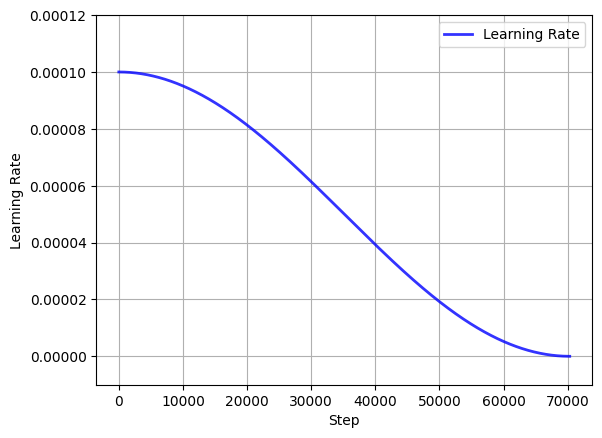

In [ ]:
# optimizer = optim.Adam(nn.Linear(1, 1).parameters(), lr=0)
# scheduler = NoamScheduler(optimizer, hidden_dim=model.hidden_dim, warmup_steps=warmup_steps, LR_scale=LR_scale)
# plot_scheduler(scheduler_name = 'Noam', optimizer = optimizer, scheduler = scheduler, total_steps = int(len(train_DS)*EPOCH/BATCH_SIZE))

# optimizer = optim.Adam(nn.Linear(1, 1).parameters(), lr=0)
# scheduler = LinearWarmupLinearDecayScheduler(optimizer, warmup_steps=warmup_steps, total_steps = int(len(train_DS)*EPOCH/BATCH_SIZE), max_lr=LR_peak)
# plot_scheduler(scheduler_name = 'Linear', optimizer = optimizer, scheduler = scheduler, total_steps = int(len(train_DS)*EPOCH/BATCH_SIZE))

optimizer = optim.Adam(nn.Linear(1, 1).parameters(), lr=LR_init)
scheduler = CosineAnnealingLR(optimizer, T_max = int(len(train_DS)*EPOCH/BATCH_SIZE))
plot_scheduler(scheduler_name = 'Cos', optimizer = optimizer, scheduler = scheduler, total_steps = int(len(train_DS)*EPOCH/BATCH_SIZE))

## 모델 학습

In [ ]:
if new_model_train:
    params = [p for p in model.parameters() if p.requires_grad] # 사전 학습된 layer를 사용할 경우
    if scheduler_name == 'Noam':
        optimizer = optim.AdamW(params, lr=0, weight_decay=LAMBDA)
        scheduler = NoamScheduler(optimizer, hidden_dim=model.hidden_dim, warmup_steps=warmup_steps, LR_scale=LR_scale)
    elif scheduler_name == 'Linear':
        optimizer = optim.AdamW(params, lr=0, weight_decay=LAMBDA)
        scheduler = LinearWarmupLinearDecayScheduler(optimizer, warmup_steps=warmup_steps, total_steps = int(len(train_DS)*EPOCH/BATCH_SIZE), max_lr=LR_peak)
    elif scheduler_name == 'Cos':
        optimizer = optim.AdamW(params, lr=LR_init, weight_decay=LAMBDA)
        scheduler = CosineAnnealingLR(optimizer, T_max = int(len(train_DS)*EPOCH/BATCH_SIZE))
    elif scheduler_name == 'Constant':
        optimizer = optim.AdamW(params, lr=LR, weight_decay=LAMBDA)
        scheduler = None
    Train(model, train_DL, val_DL, criterion, optimizer, scheduler)

In [ ]:
loaded = torch.load(save_model_path, map_location=DEVICE)
load_model = loaded["model"]
ep = loaded["ep"]
optimizer = loaded["optimizer"]
scheduler = loaded["scheduler"]

loaded = torch.load(save_history_path, map_location=DEVICE)
loss_history = loaded["loss_history"]
acc_history = loaded["acc_history"]

print(ep)
print(optimizer)

30
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0001
    lr: 3.154484479238077e-05
    maximize: False
    weight_decay: 0.3
)


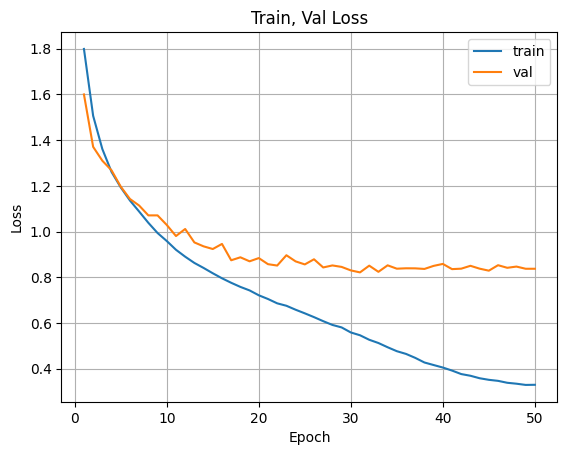

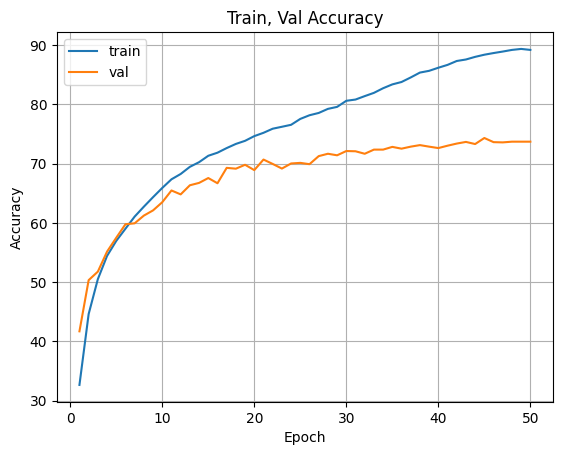

In [ ]:
plt.figure()
plt.plot(range(1,EPOCH+1), loss_history["train"], label="train")
plt.plot(range(1,EPOCH+1), loss_history["val"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.legend()
plt.grid()

plt.figure()
plt.plot(range(1,EPOCH+1), acc_history["train"], label="train")
plt.plot(range(1,EPOCH+1), acc_history["val"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train, Val Accuracy")
plt.legend()
plt.grid()

In [ ]:
Test(load_model, test_DL, criterion)
print(count_params(load_model))

Test loss: 0.801
Test accuracy: 7303/10000 (73.0 %)
2507530


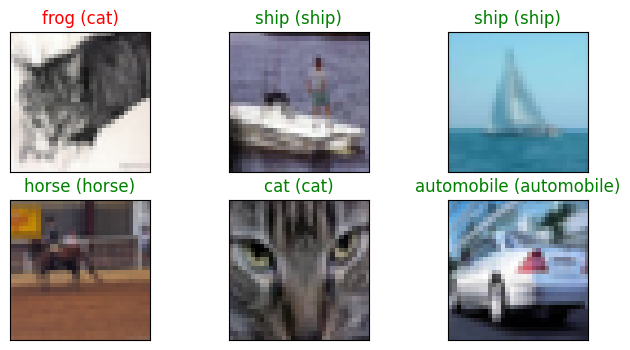

In [ ]:
Test_plot(load_model,test_DL)